# Tutorial 2: Training a Customized RBM on MNIST Dataset

In this second tutorial on training RBMs using xRBM, we also explore different ways to customize the model and its learning procedure. 

You are expected to be familar with the basics that are explained in the first tutorial.

##  The Imports
First, we import Tensorflow and numpy packages, as well as the packages we need to visualize the learned filters.

We import the `xrbm.models` module, which contains the RBM model class, as well as the `xrbm.train` module, which contains the `CD-k` approximation algorithm that we use for training our RBM.

In [4]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import sys
sys.path.append('../')

import xrbm.models
import xrbm.train

from xrbm.utils.vizutils import *

## Get the Training Data

We use the MNIST dataset that is provided by the Tensorflow package:

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

data_sets = input_data.read_data_sets('MNIST_data', False)
training_data = data_sets.train.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Set Up the Parameters

The number of the visible units of the RBM equals to the number of the dimensions of the training data. As each image in MNIST is `28x28`, the number of total pixels is `784`. 

We use `200` hidden units, choose a learning rate of `0.1`, and set to train the model for `15` epochs.

In [6]:
num_vis         = training_data[0].shape[0] #=784
num_hid         = 200
learning_rate   = 0.1
batch_size      = 100
training_epochs = 15

## Using Momentum

We can use [momentum](http://ufldl.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/) in order to speed up the learning. Note that, usually, momentum is used only after the first few epochs in order to allow the gradients to find their correct direction and stablize.

We create the RBM object and mini-batch indices as before:

In [27]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

rbm = xrbm.models.RBM(num_vis=num_vis, num_hid=num_hid, name='rbm_mnist')

batch_idxs     = np.random.permutation(range(len(training_data)))
n_batches      = len(batch_idxs) // batch_size

We create a new placeholder to store the value of the momentum coeficient:

In [28]:
batch_data     = tf.placeholder(tf.float32, shape=(None, num_vis))
momentum       = tf.placeholder(tf.float32, shape=())

We createt he ops as before, but this time we pass the moemntum placeholder to the CDApproximator instance:

In [29]:
cdapproximator = xrbm.train.CDApproximator(learning_rate=learning_rate, 
                                           momentum=momentum)

train_op       = cdapproximator.train(rbm, vis_data=batch_data)
rec_cost_op    = rbm.get_reconstruction_cost(batch_data)

Finally, we are ready to run everything and see the results:

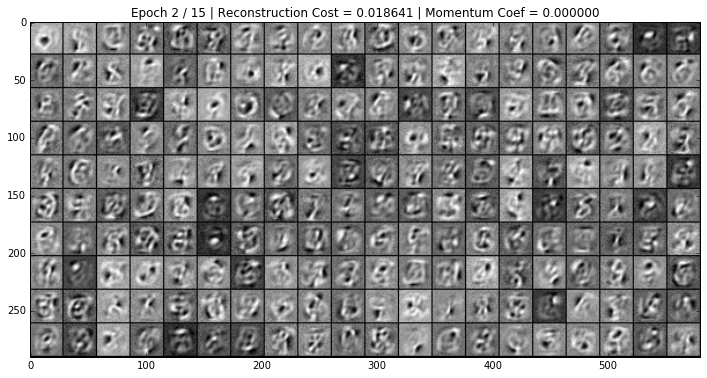

KeyboardInterrupt: 

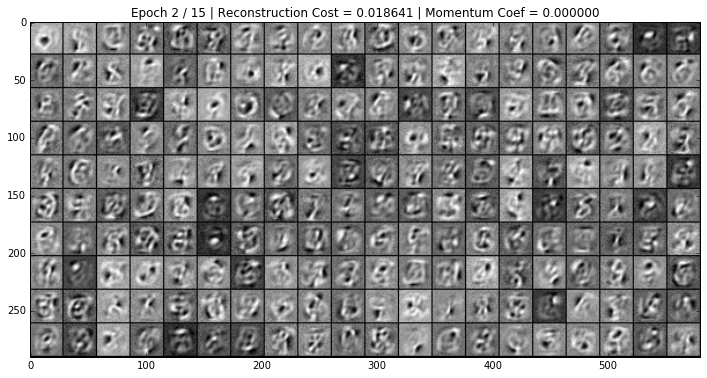

In [30]:
# Create figure first so that we use the same one to draw the filters on during the training
fig = plt.figure(figsize=(12,8))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):


        if epoch < 5: # for the first 5 epochs, we use a momentum coeficient of 0 
            epoch_momentum = 0
        else: # once the training is stablized, we use a momentum coeficient of 0.9
            epoch_momentum = 0.9

        for batch_i in range(n_batches):
            # Get just minibatch amount of data
            idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

            # Run the training step
            sess.run(train_op, feed_dict={batch_data: training_data[idxs_i], momentum: epoch_momentum})

        reconstruction_cost = sess.run(rec_cost_op, feed_dict={batch_data: training_data})
        
        # visualizing the filters grid
        
        # evaluating the value of the RBM's weight tensor
        W = rbm.W.eval().transpose()
        
        # using a utility function to put together all the filters
        filters_grid = create_2d_filters_grid(W, filter_shape=(28,28), grid_size=(10, 20), grid_gap=(1,1))

        title = ('Epoch %i / %i | Reconstruction Cost = %f | Momentum Coef = %f'%
                (epoch+1, training_epochs, reconstruction_cost, epoch_momentum))

        plt.title(title)
        plt.imshow(filters_grid, cmap='gray')
        display.clear_output(wait=True)
        display.display(fig)
        

## Using Other Initializers

By defualt, the RBM uses the [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf) algorithm to initialize its weight tensor. You can change this by passing a different initializer to the RBM:

In [ ]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

rbm = xrbm.models.RBM(num_vis=num_vis, num_hid=num_hid,
                      initializer=tf.contrib.layers.xavier_initializer(),
                      name='rbm_mnist')

## Using Other Activation Functions

RBM's default activation function is the `sigmoid` function. But you can use any activation function. Here, we try the [Exponential Linear Units (ELUs)](https://arxiv.org/abs/1511.07289):

In [34]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

rbm = xrbm.models.RBM(num_vis=num_vis, num_hid=num_hid,
                      initializer=tf.contrib.layers.xavier_initializer(),
                      activation=tf.nn.elu,
                      name='rbm_mnist')

In [35]:
batch_idxs     = np.random.permutation(range(len(training_data)))
n_batches      = len(batch_idxs) // batch_size

batch_data     = tf.placeholder(tf.float32, shape=(None, num_vis))
momentum       = tf.placeholder(tf.float32, shape=())

cdapproximator = xrbm.train.CDApproximator(learning_rate=learning_rate, momentum=momentum)
train_op       = cdapproximator.train(rbm, vis_data=batch_data)
rec_cost_op    = rbm.get_reconstruction_cost(batch_data)

Finally, we are ready to run everything and see the results:

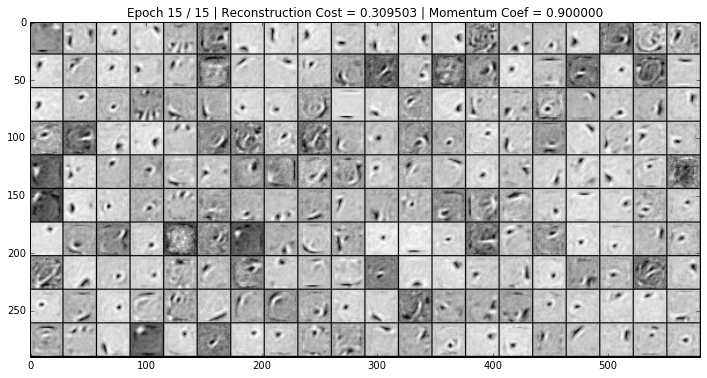

In [ ]:
# Create figure first so that we use the same one to draw the filters on during the training
fig = plt.figure(figsize=(12,8))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):


        if epoch < 5: # for the first 5 epochs, we use a momentum coeficient of 0 
            epoch_momentum = 0
        else: # once the training is stablized, we use a momentum coeficient of 0.9
            epoch_momentum = 0.9

        for batch_i in range(n_batches):
            # Get just minibatch amount of data
            idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

            # Run the training step
            sess.run(train_op, feed_dict={batch_data: training_data[idxs_i], momentum: epoch_momentum})

        reconstruction_cost = sess.run(rec_cost_op, feed_dict={batch_data: training_data})
        
        # visualizing the filters grid
        
        # evaluating the value of the RBM's weight tensor
        W = rbm.W.eval().transpose()
        
        # using a utility function to put together all the filters
        filters_grid = create_2d_filters_grid(W, filter_shape=(28,28), grid_size=(10, 20), grid_gap=(1,1))

        title = ('Epoch %i / %i | Reconstruction Cost = %f | Momentum Coef = %f'%
                (epoch+1, training_epochs, reconstruction_cost, epoch_momentum))

        plt.title(title)
        plt.imshow(filters_grid, cmap='gray')
        display.clear_output(wait=True)
        display.display(fig)
        

## Using Regularization

We can also add [regularizers]() to the `CDApprozimator`. 

For this, we create the model as before:

In [ ]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

rbm = xrbm.models.RBM(num_vis=num_vis, num_hid=num_hid,
                      initializer=tf.contrib.layers.xavier_initializer(),
                      activation=tf.nn.sigmoid,
                      name='rbm_mnist')

batch_idxs     = np.random.permutation(range(len(training_data)))
n_batches      = len(batch_idxs) // batch_size

batch_data     = tf.placeholder(tf.float32, shape=(None, num_vis))
momentum       = tf.placeholder(tf.float32, shape=())

Add add an argument to the `CDApproximator` to specify the regularizer:

In [32]:
cdapproximator = xrbm.train.CDApproximator(learning_rate=learning_rate, 
                                           momentum=momentum,
                                          regularizer=tf.contrib.layers.l1_regularizer(0.001))

train_op       = cdapproximator.train(rbm, vis_data=batch_data)
rec_cost_op    = rbm.get_reconstruction_cost(batch_data)

Finally, we are ready to run everything and see the results:

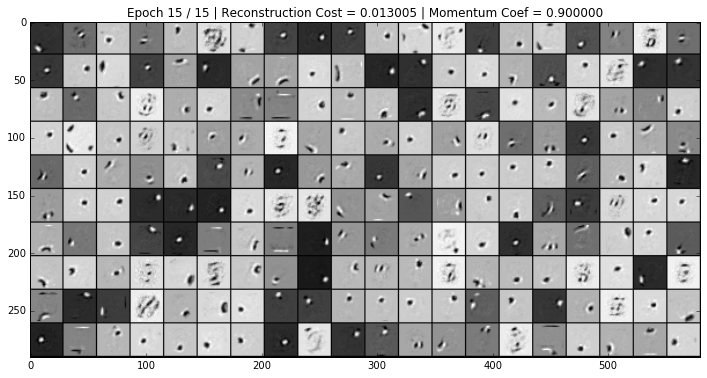

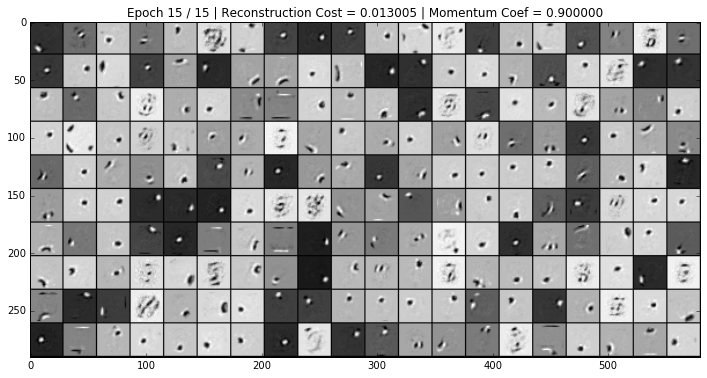

In [33]:
# Create figure first so that we use the same one to draw the filters on during the training
fig = plt.figure(figsize=(12,8))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):


        if epoch < 5: # for the first 5 epochs, we use a momentum coeficient of 0 
            epoch_momentum = 0
        else: # once the training is stablized, we use a momentum coeficient of 0.9
            epoch_momentum = 0.9

        for batch_i in range(n_batches):
            # Get just minibatch amount of data
            idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

            # Run the training step
            sess.run(train_op, feed_dict={batch_data: training_data[idxs_i], momentum: epoch_momentum})

        reconstruction_cost = sess.run(rec_cost_op, feed_dict={batch_data: training_data})
        
        # visualizing the filters grid
        
        # evaluating the value of the RBM's weight tensor
        W = rbm.W.eval().transpose()
        
        # using a utility function to put together all the filters
        filters_grid = create_2d_filters_grid(W, filter_shape=(28,28), grid_size=(10, 20), grid_gap=(1,1))

        title = ('Epoch %i / %i | Reconstruction Cost = %f | Momentum Coef = %f'%
                (epoch+1, training_epochs, reconstruction_cost, epoch_momentum))

        plt.title(title)
        plt.imshow(filters_grid, cmap='gray')
        display.clear_output(wait=True)
        display.display(fig)
        